In [1]:
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd

from hmmlearn import hmm

In [2]:
# Prepare parameters for a 4-components HMM
# Initial population probability
startprob = np.array([0.6, 0.3, 0.1, 0.0])

# The transition matrix, note that there are no transitions possible
# between component 1 and 3
transmat = np.array([[0.7, 0.2, 0.0, 0.1],
                     [0.3, 0.5, 0.2, 0.0],
                     [0.0, 0.3, 0.5, 0.2],
                     [0.2, 0.0, 0.2, 0.6]])

# The means of each component
means = np.array([[0.0,  0.0],
                  [0.0, 11.0],
                  [9.0, 10.0],
                  [11.0, -1.0]])

# The covariance of each component
covars = .5 * np.tile(np.identity(2), (4, 1, 1))

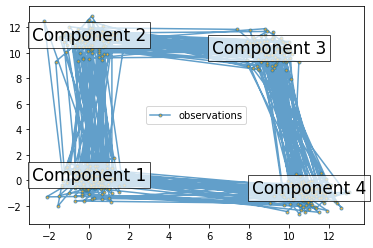

In [3]:
# Build an HMM instance and set parameters
model = hmm.GaussianHMM(n_components=4, covariance_type="full")

# Instead of fitting it from the data, we directly set the estimated
# parameters, the means and covariance of the components
model.startprob_ = startprob
model.transmat_ = transmat
model.means_ = means
model.covars_ = covars

# Generate samples
X, Z = model.sample(500)

# Plot the sampled data
plt.plot(X[:, 0], X[:, 1], ".-", label="observations", ms=6,
         mfc="orange", alpha=0.7)

# Indicate the component numbers
for i, m in enumerate(means):
    plt.text(m[0], m[1], 'Component %i' % (i + 1),
             size=17, horizontalalignment='center',
             bbox=dict(alpha=.7, facecolor='w'))
plt.legend(loc='best')
plt.show()

## Hidden Markov Models on Divvy Bike Trips

In this lab we will explore how to train a hidden Markov model (HMM) on a temporal sequence. We will use the Divvy bikeshare data, and in particular the total ride duration over time, to train the model, and subsequently use the trained model to generate a sequence based on the transitions.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

from hmmlearn import hmm

### Load the Data

In [5]:
df = pd.read_csv("../data/Divvy_Trips_2018.csv.gz", compression='gzip')
df.head()

,TRIP ID,START TIME,STOP TIME,BIKE ID,TRIP DURATION,FROM STATION ID,FROM STATION NAME,TO STATION ID,TO STATION NAME,USER TYPE,GENDER,BIRTH YEAR,FROM LATITUDE,FROM LONGITUDE,FROM LOCATION,TO LATITUDE,TO LONGITUDE,TO LOCATION
0,18511623,05/21/2018 05:07:29 PM,05/21/2018 05:11:48 PM,153,259,51,Clark St & Randolph St,91,Clinton St & Washington Blvd,Subscriber,Male,1982.0,41.884576,-87.631890,POINT (-87.63188991 41.884576228),41.883380,-87.641170,POINT (-87.64117 41.88338)
1,18002370,04/01/2018 02:24:43 PM,04/01/2018 02:38:54 PM,3101,851,106,State St & Pearson St,174,Canal St & Madison St,Subscriber,Female,1990.0,41.897448,-87.628722,POINT (-87.628722 41.897448),41.882091,-87.639833,POINT (-87.639833 41.882091)
2,18002371,04/01/2018 02:25:30 PM,04/01/2018 02:32:41 PM,5226,431,426,Ellis Ave & 60th St,322,Kimbark Ave & 53rd St,Subscriber,Male,1982.0,41.785097,-87.601073,POINT (-87.6010727606 41.78509714636),41.799568,-87.594747,POINT (-87.594747 41.799568)
3,18002372,04/01/2018 02:25:51 PM,04/01/2018 02:42:22 PM,4861,991,110,Dearborn St & Erie St,31,Franklin St & Chicago Ave,Subscriber,Male,1977.0,41.893992,-87.629318,POINT (-87.629318 41.893992),41.896776,-87.635633,POINT (-87.635633 41.896776)
4,18002373,04/01/2018 02:25:58 PM,04/01/2018 02:42:23 PM,4706,985,214,Damen Ave & Grand Ave,47,State St & Kinzie St,Subscriber,Male,1984.0,41.891220,-87.676860,POINT (-87.67686 41.89122),41.889187,-87.627754,POINT (-87.627754 41.889187)


### Create a Timeseries of Total Duration by Date

Let's pull out the start time and trip duration, and then group the durations by date, giving us total trip duration (i.e., total amount of time on Divvy bikes) over the calendar year.  

In [6]:
rides = df.loc[:,['START TIME','TRIP DURATION']]
rides.head()

,START TIME,TRIP DURATION
0,05/21/2018 05:07:29 PM,259
1,04/01/2018 02:24:43 PM,851
2,04/01/2018 02:25:30 PM,431
3,04/01/2018 02:25:51 PM,991
4,04/01/2018 02:25:58 PM,985


In [7]:
# This takes a long time.
rides['Date'] = pd.to_datetime(rides['START TIME']).dt.date

In [8]:
rides.sort_values(by='START TIME', inplace=True)
rides.head()

,START TIME,TRIP DURATION,Date
1115179,01/01/2018 01:00:00 AM,794,2018-01-01
1114638,01/01/2018 01:02:00 PM,329,2018-01-01
1115121,01/01/2018 01:07:00 AM,1481,2018-01-01
1114820,01/01/2018 01:08:00 AM,1361,2018-01-01
1114920,01/01/2018 01:08:00 PM,392,2018-01-01


We can see some seasonal trends, effectively representing two modes (summer and winter, essentially)

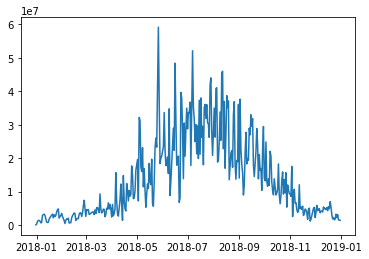

In [9]:
X = rides.groupby('Date').sum()
plt.plot(X)
plt.show()

### Training a Hidden Markov Model

We can create an HMM, fit the model to the observations, which results in a prediction of most likely states. We can then look at those states.

In [10]:
model = hmm.GaussianHMM(n_components=2, n_iter=1000)
model.fit(X)

GaussianHMM(algorithm='viterbi', covariance_type='diag', covars_prior=0.01,
            covars_weight=1, init_params='stmc', means_prior=0, means_weight=0,
            min_covar=0.001, n_components=2, n_iter=1000, params='stmc',
            random_state=None, startprob_prior=1.0, tol=0.01,
            transmat_prior=1.0, verbose=False)

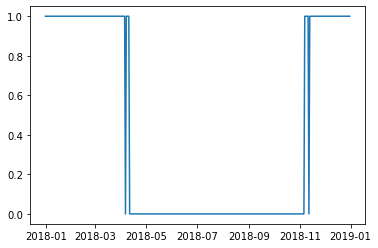

In [11]:
X['states'] = model.predict(X)

plt.plot(X['states'])
plt.show()

### Generating Additional Sequences

Once we have trained the model, it is possible to generate additional sequences based on the learned transition probabilities.

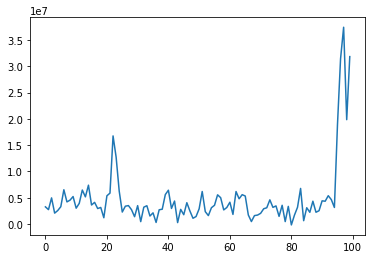

In [12]:
p = model.sample(100)
plt.plot(p[0])
plt.show()

In [13]:
p[1]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0])